# Customer Churn Prediction and Analysis for Telecommunication Service


**Summary** 


*   Designed algorithms to predict customer churn probability via labeled data of telecom service on Python
*Conducted exploration data analysis on correlation to better understand features 
*Trained logistic regression, KNN and random forest with optimized parameters to prevent overfitting, evaluated models with precision, recall and AUC to find the best AUC score of 91% from random forest
*Analyzed feature importance to identify the most important features for the churn prediction


## Contents


* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Feature Selection](#Part-4:-Feature-Selection)

# Part 0: Setup Google Drive Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Data"

Aassignment.docx       Product2.csv	     train.csv
churn.csv	       rf_best_co.sav	     TVdata.txt
FB.csv		       rf_best_new.sav	     uk_rain_2014.csv
Historical_sales2.csv  stanford_car_dataset
Predicted_list2.csv    test.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
churn_df = pd.read_csv('drive/My Drive/Data/churn.csv') 
churn_df.head() #all numerical

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


# Part 1: Exploration Data Analysis

### Part 1.1: Understand the Raw Dataset

In [ ]:
churn_df['churned'].value_counts()

 False.    4293
 True.      707
Name: churned, dtype: int64

In [ ]:
#null checking
churn_df.isna().sum()

state                            0
account_length                   0
area_code                        0
phone_number                     0
intl_plan                        0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churned                          0
dtype: int64

In [ ]:
import pandas_profiling
#pandas_profiling.ProfileReport(churn_df)

churn_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
account_length,5000.0,100.258600,39.694560,1.0,73.000,100.00,127.00,243.00
area_code,5000.0,436.911400,42.209182,408.0,408.000,415.00,415.00,510.00
number_vmail_messages,5000.0,7.755200,13.546393,0.0,0.000,0.00,17.00,52.00
total_day_minutes,5000.0,180.288900,53.894699,0.0,143.700,180.10,216.20,351.50
total_day_calls,5000.0,100.029400,19.831197,0.0,87.000,100.00,113.00,165.00
total_day_charge,5000.0,30.649668,9.162069,0.0,24.430,30.62,36.75,59.76
total_eve_minutes,5000.0,200.636560,50.551309,0.0,166.375,201.00,234.10,363.70
total_eve_calls,5000.0,100.191000,19.826496,0.0,87.000,100.00,114.00,170.00
total_eve_charge,5000.0,17.054322,4.296843,0.0,14.140,17.09,19.90,30.91
total_night_minutes,5000.0,200.391620,50.527789,0.0,166.900,200.40,234.70,395.00


### Part 1.2: Data cleaning

Remove Extra Whitespace

In [ ]:
# check categorical feature
churn_df['voice_mail_plan'][0]

' yes'

In [ ]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].apply(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].apply(lambda x: x.strip())

In [ ]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

### Part 1.3:  Understand the features

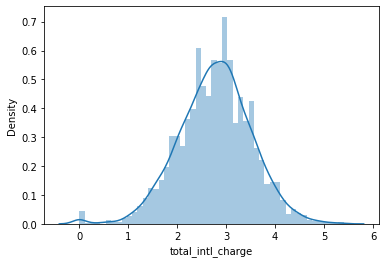

In [ ]:
# check the feature distribution
sns.distplot(churn_df['total_intl_charge'])

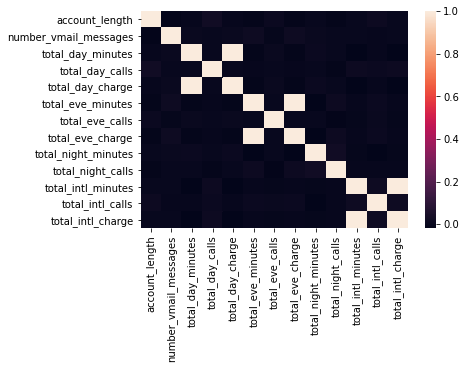

In [ ]:
# correlations between all the features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

# show heatmap of correlations
sns.heatmap(corr)

In [ ]:
# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.000391,-0.000156,0.000368


In [ ]:
# calculate two features correlation, same result as above
from scipy.stats import pearsonr
print (pearsonr(churn_df['total_day_minutes'], churn_df['number_vmail_messages']))
#[0]: Pearson’s correlation coefficient [1]:p-value

(0.00538137596065452, 0.7036274686569617)


# Part 2: Feature Preprocessing

In [ ]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
# Get ground truth data 
y = np.where(churn_df['churned'] == 'True.',1,0)
# Drop some useless columns
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)

# yes and no have to be converted to boolean values (True or False)

yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

X = churn_feat_space

#churn_feat_space[1:5][['intl_plan','voice_mail_plan']]

In [ ]:
# check the propotion of y = 1
print(y.sum() / y.shape * 100)
#print(y[0:20])

[14.14]


# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [ ]:
# Splite data into training and testing
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 4000 observation with 17 features
test data has 1000 observation with 17 features


In [ ]:

# Considering not use any info from test, do the same modification for testing data as well as training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

### Part 3.2: Model Training and Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

classifier_logistic = LogisticRegression()
classifier_KNN = KNeighborsClassifier()
classifier_RF = RandomForestClassifier()
classifier_SVC = SVC()

In [ ]:
# Train the model
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Prediction of test data
classifier_logistic.predict(X_test)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [ ]:
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

#same as above
#predicted = classifier_logistic.predict(X_test)
#accuracy_score(y_test, predicted)

0.861

In [ ]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest', 'SVM']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_SVC]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.8725  0.865   0.87    0.8625  0.86875]
Model accuracy of Logistic Regression is 0.86775
[0.89125 0.90375 0.89625 0.89125 0.90125]
Model accuracy of KNN is 0.8967499999999999
[0.9425  0.96    0.95    0.97    0.94875]
Model accuracy of Random Forest is 0.95425
[0.92    0.9225  0.92    0.91375 0.91625]
Model accuracy of SVM is 0.9185000000000001


### Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    #parameters from gs
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5) ('l1', 10) ('l2', 1) ('l2', 5) ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 5, 10), 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# the best score and hyperparameter
print_grid_search_metrics(Grid_LR)

Best score: 0.86775
Best parameters set:
C:1
penalty:l2


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [ ]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [ ]:
# # the best score and hyperparameter
print_grid_search_metrics(Grid_KNN)

Best score: 0.8967499999999999
Best parameters set:
n_neighbors:5


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.9540000000000001
Best parameters set:
n_estimators:60


In [ ]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

###Part 3.4: Model Evaluation



#### Part 3.4.1: Precision, Recall, Accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.963
precision is: 0.9649122807017544
recall is: 0.7692307692307693


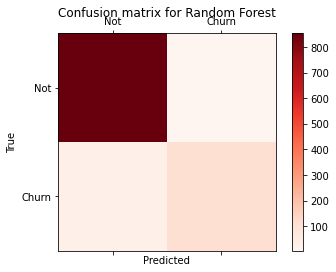

Logistic Regression
Accuracy is: 0.861
precision is: 0.5344827586206896
recall is: 0.21678321678321677


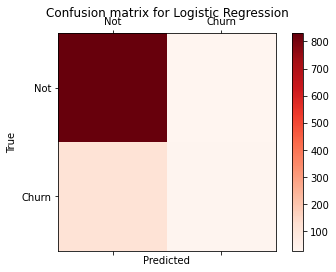

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

#### Part 3.4.2: ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

##### Part 3.4.2.1: ROC & AUC of RF Model

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

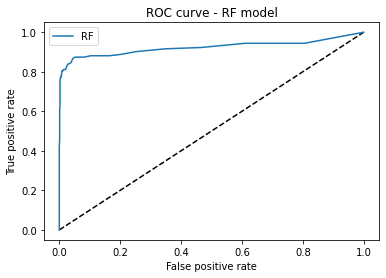

In [ ]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.9229994043296261

##### Part 3.4.2.2: ROC of LR Model

In [ ]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

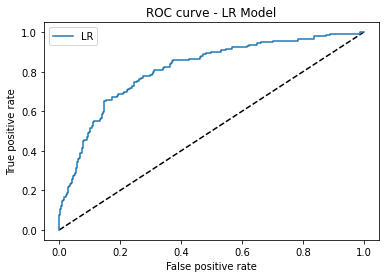

In [ ]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.8129105433656192

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

In [ ]:
# add L2 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]
print (LRmodel_l2.coef_[0].shape)
print ("Logistic Regression (L2) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l2.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))
  

(17,)
Logistic Regression (L2) Coefficients
number_customer_service_calls: 0.6604
voice_mail_plan: -0.6199
intl_plan: 0.6039
total_day_minutes: 0.3626
total_day_charge: 0.3621
total_eve_charge: 0.1766
total_eve_minutes: 0.1764
total_intl_calls: -0.1715
number_vmail_messages: 0.1659
total_intl_charge: 0.1204
total_intl_minutes: 0.12
total_night_minutes: 0.0997
total_night_charge: 0.0992
account_length: 0.0548
total_day_calls: 0.0501
total_night_calls: -0.0313
total_eve_calls: -0.0296


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_day_minutes: 0.1471
total_day_charge: 0.1414
number_customer_service_calls: 0.1165
intl_plan: 0.0914
total_eve_minutes: 0.0665
total_eve_charge: 0.0623
total_intl_calls: 0.0555
total_night_minutes: 0.0408
total_intl_minutes: 0.0407
total_intl_charge: 0.0393
total_night_charge: 0.0386
voice_mail_plan: 0.0278
number_vmail_messages: 0.0276
total_day_calls: 0.0273
total_night_calls: 0.0264
account_length: 0.0261
total_eve_calls: 0.0247
